In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from itertools import product

In [18]:
hdfc  = pd.read_excel('HDFC 2019-2022.xlsx')
sbi  = pd.read_excel('SBI 2019-2022.xlsx')
ongc  = pd.read_excel('ONGC 2019-2022.xlsx')
indian_oil  = pd.read_excel('Indian Oil 2019-2022.xlsx')
gail  = pd.read_excel('GAIL 2019-2022.xlsx')
bpcl  = pd.read_excel('BPCL 2019-2022.xlsx')

## Data Cleaning

In [19]:
hdfc.head()

,Date,Open,High,Low,Close,Volume,- SPREAD -,Unnamed: 7
0,NaT,NaN,NaN,NaN,NaN,NaN,(High-Low),(Open-Close)
1,2022-12-30,1643.50,1644.0,1620.0,1627.30,50172.0,24,16.2
2,2022-12-29,1618.15,1643.4,1611.1,1640.90,83082.0,32.3,-22.75
3,2022-12-28,1629.00,1632.9,1623.0,1629.45,132818.0,9.9,-0.45
4,2022-12-27,1632.30,1635.7,1615.0,1630.65,90688.0,20.7,1.65


In [20]:
hdfc.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']
sbi.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']
ongc.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']
indian_oil.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']
gail.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']
bpcl.columns = ['Date','Open','High','Low','Close','Volume','Spread_high_low', 'Spread_open_close']

In [21]:
hdfc = hdfc.iloc[1:]
sbi = sbi.iloc[1:]
ongc = ongc.iloc[1:]
indian_oil = indian_oil.iloc[1:]
gail = gail.iloc[1:]
bpcl = bpcl.iloc[1:]

In [22]:
bpcl.head()

,Date,Open,High,Low,Close,Volume,Spread_high_low,Spread_open_close
1,2022-12-30,329.85,332.95,327.55,330.55,65866.0,5.4,-0.7
2,2022-12-29,323.00,328.00,320.20,327.05,157636.0,7.8,-4.05
3,2022-12-28,326.00,326.15,322.35,324.20,98206.0,3.8,1.8
4,2022-12-27,328.85,328.85,323.00,326.05,37705.0,5.85,2.8
5,2022-12-26,320.05,328.40,320.05,324.70,77010.0,8.35,-4.65


In [23]:
hdfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 1 to 993
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               993 non-null    datetime64[ns]
 1   Open               993 non-null    float64       
 2   High               993 non-null    float64       
 3   Low                993 non-null    float64       
 4   Close              993 non-null    float64       
 5   Volume             993 non-null    float64       
 6   Spread_high_low    993 non-null    object        
 7   Spread_open_close  993 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 62.2+ KB


In [25]:
hdfc.set_index('Date', inplace = True)       # setting Date as index

In [26]:
hdfc.head()

,Open,High,Low,Close,Volume,Spread_high_low,Spread_open_close
Date,,,,,,,
2022-12-30,1643.50,1644.00,1620.0,1627.30,50172.0,24,16.2
2022-12-29,1618.15,1643.40,1611.1,1640.90,83082.0,32.3,-22.75
2022-12-28,1629.00,1632.90,1623.0,1629.45,132818.0,9.9,-0.45
2022-12-27,1632.30,1635.70,1615.0,1630.65,90688.0,20.7,1.65
2022-12-26,1591.00,1638.95,1591.0,1628.15,160140.0,47.95,-37.15


In [27]:
sbi.set_index('Date', inplace = True)
ongc.set_index('Date', inplace = True)
indian_oil.set_index('Date', inplace = True)
gail.set_index('Date', inplace = True)
bpcl.set_index('Date', inplace = True)

In [28]:
bpcl.head()

,Open,High,Low,Close,Volume,Spread_high_low,Spread_open_close
Date,,,,,,,
2022-12-30,329.85,332.95,327.55,330.55,65866.0,5.4,-0.7
2022-12-29,323.00,328.00,320.20,327.05,157636.0,7.8,-4.05
2022-12-28,326.00,326.15,322.35,324.20,98206.0,3.8,1.8
2022-12-27,328.85,328.85,323.00,326.05,37705.0,5.85,2.8
2022-12-26,320.05,328.40,320.05,324.70,77010.0,8.35,-4.65


In [30]:
hdfc.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Spread_high_low',
       'Spread_open_close'],
      dtype='object')

## Time Series Plots

Text(0.5, 0, 'Date')

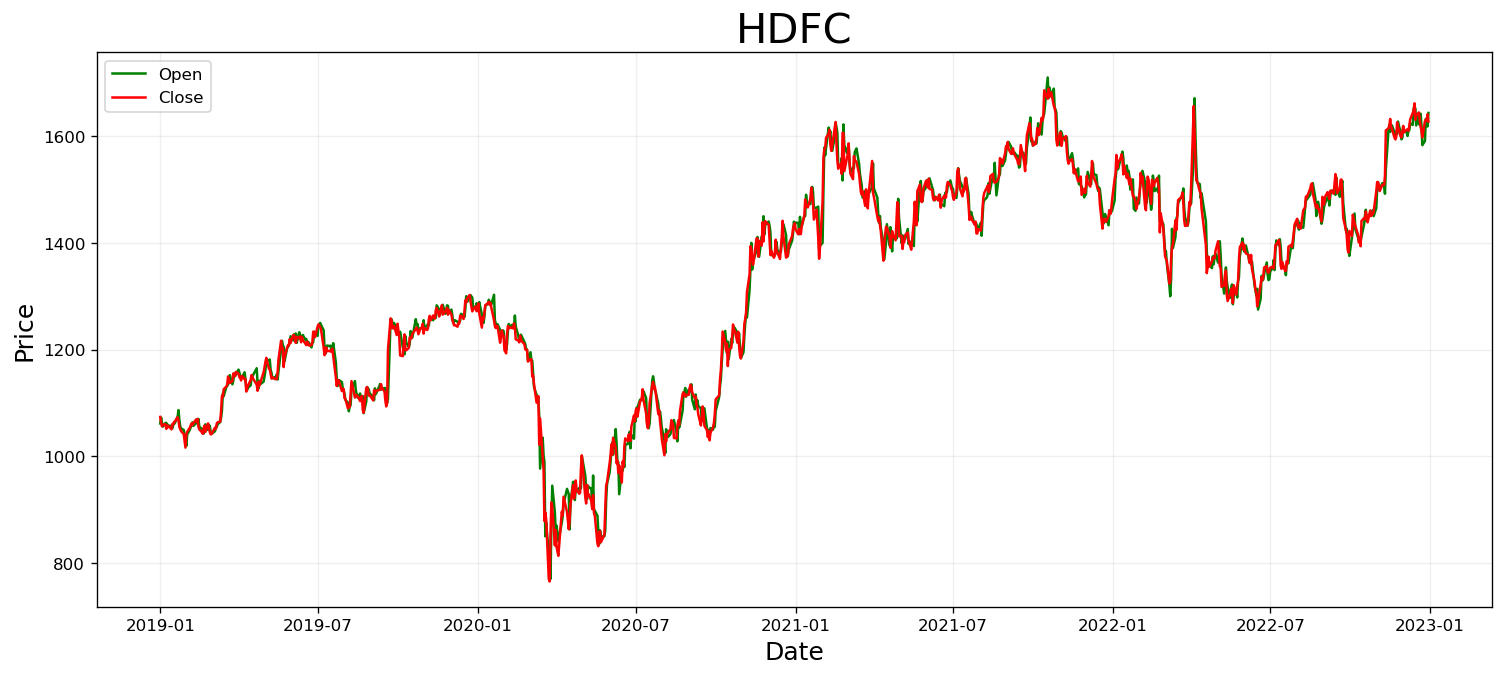

In [36]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(hdfc.Open, color = 'green', label = 'Open')
sns.lineplot(hdfc.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('HDFC', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

Text(0.5, 0, 'Date')

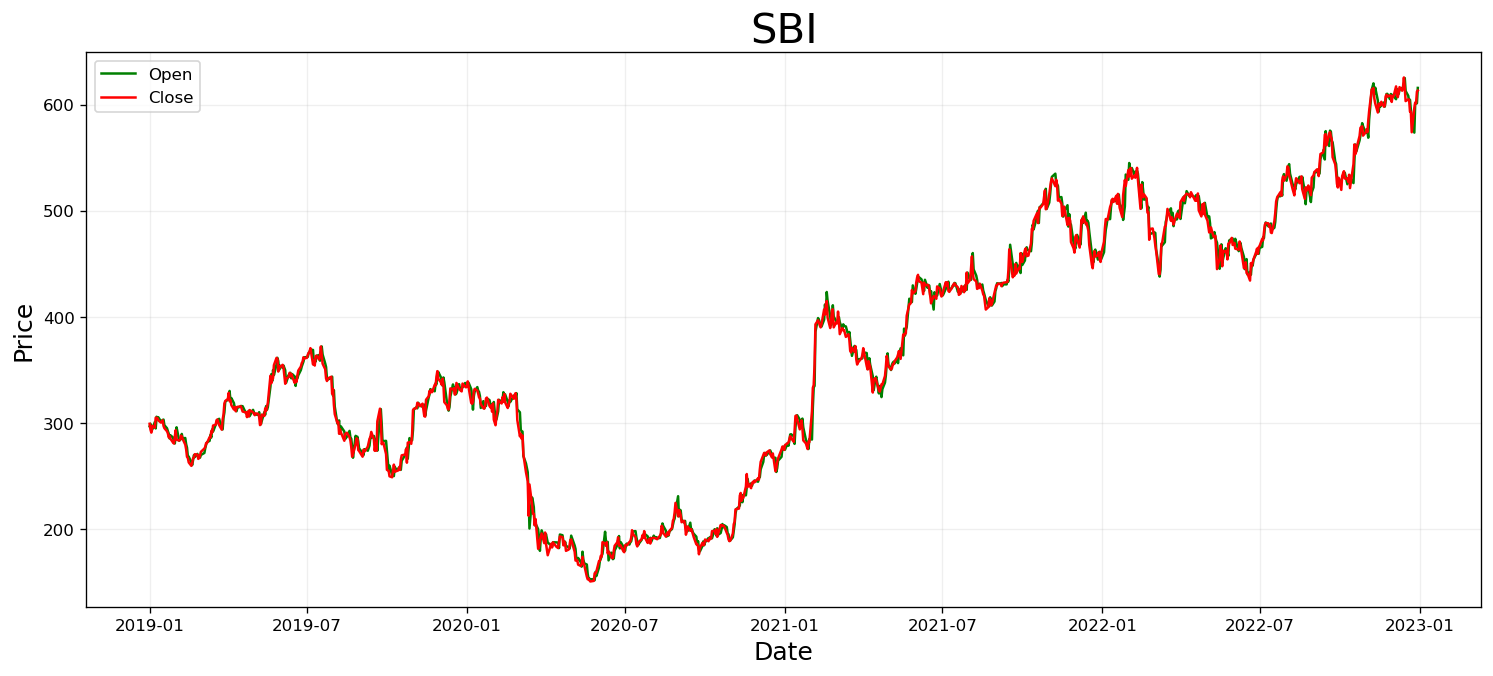

In [38]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(sbi.Open, color = 'green', label = 'Open')
sns.lineplot(sbi.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('SBI', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

Text(0.5, 0, 'Date')

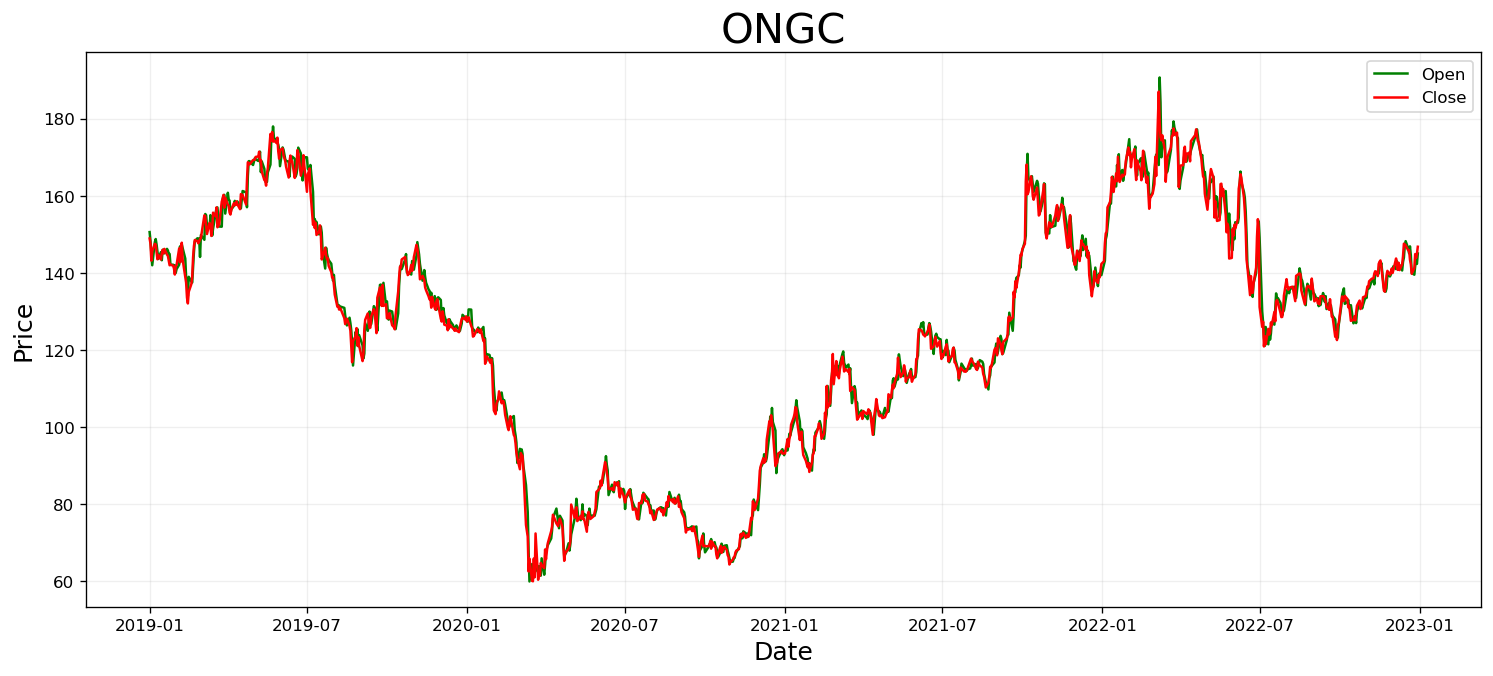

In [39]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(ongc.Open, color = 'green', label = 'Open')
sns.lineplot(ongc.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('ONGC', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

Text(0.5, 0, 'Date')

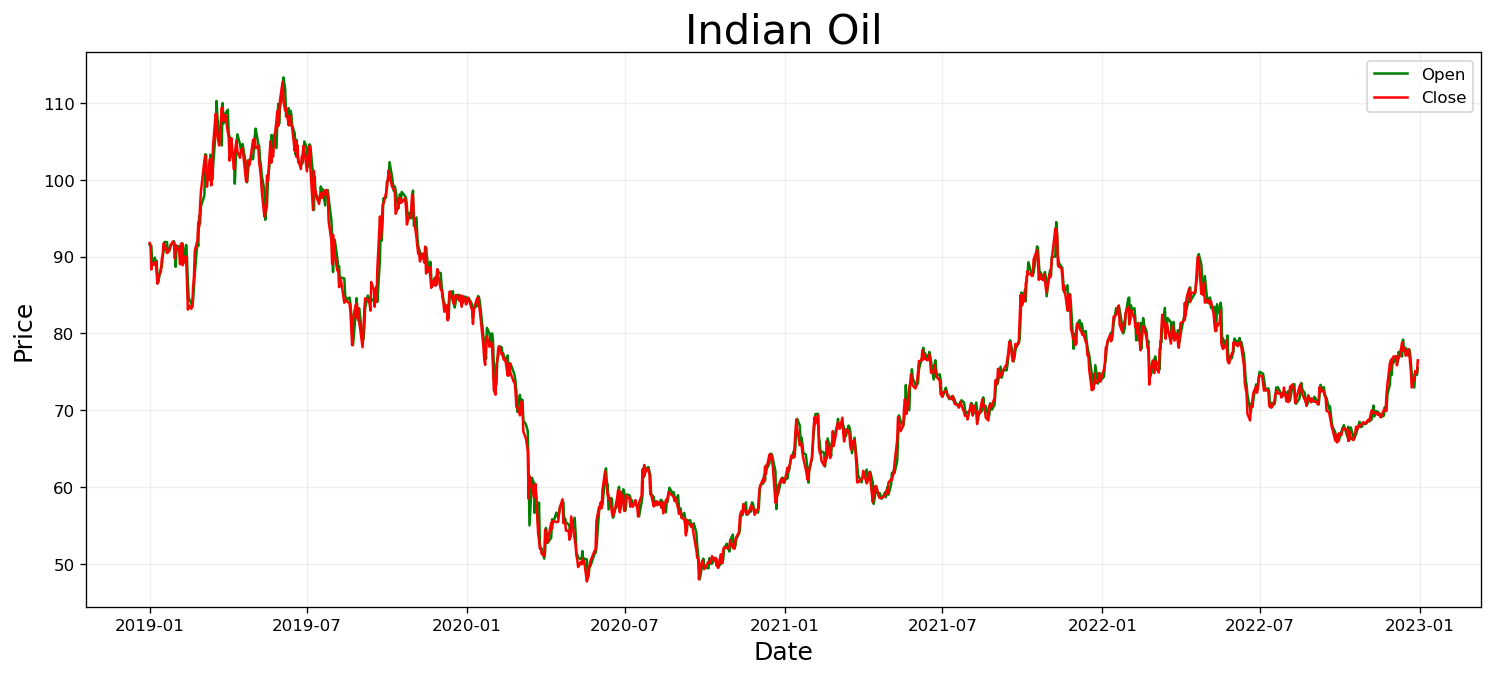

In [40]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(indian_oil.Open, color = 'green', label = 'Open')
sns.lineplot(indian_oil.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('Indian Oil', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

Text(0.5, 0, 'Date')

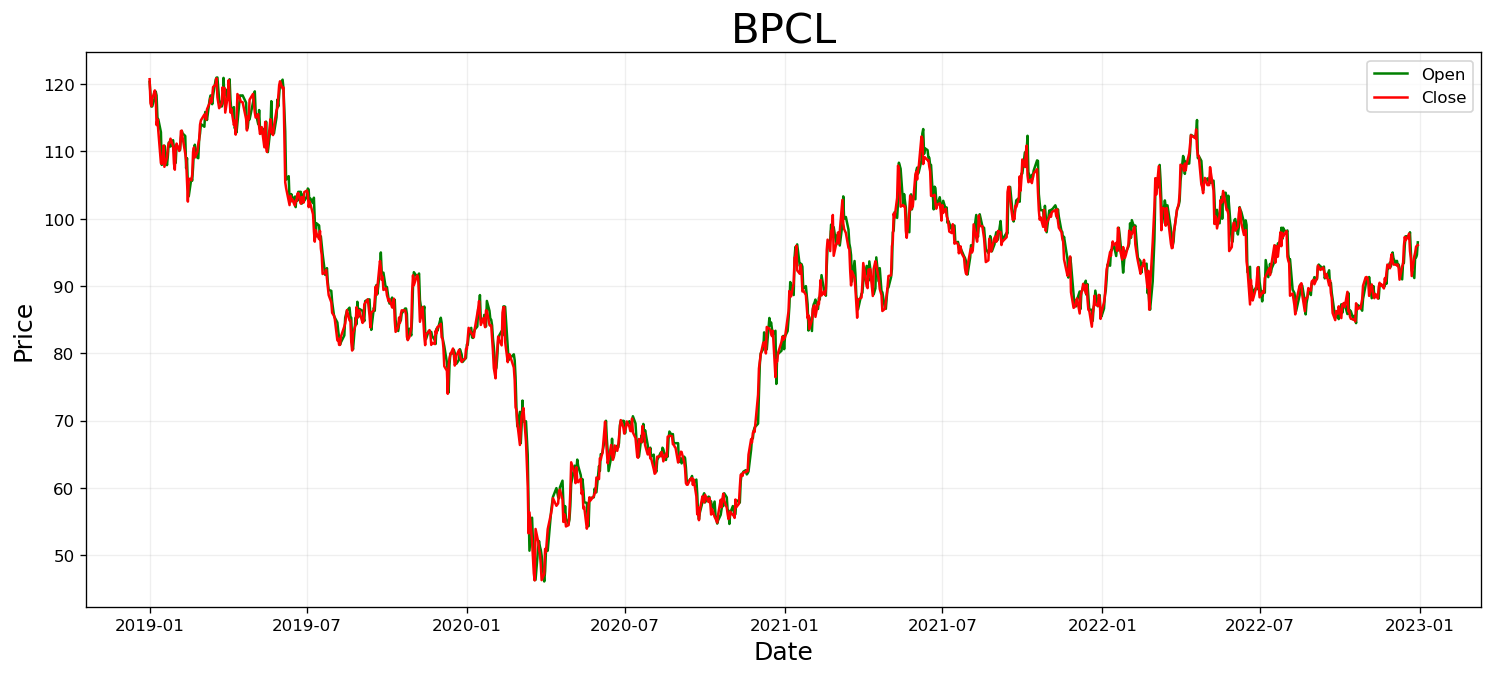

In [41]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(gail.Open, color = 'green', label = 'Open')
sns.lineplot(gail.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('BPCL', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

Text(0.5, 0, 'Date')

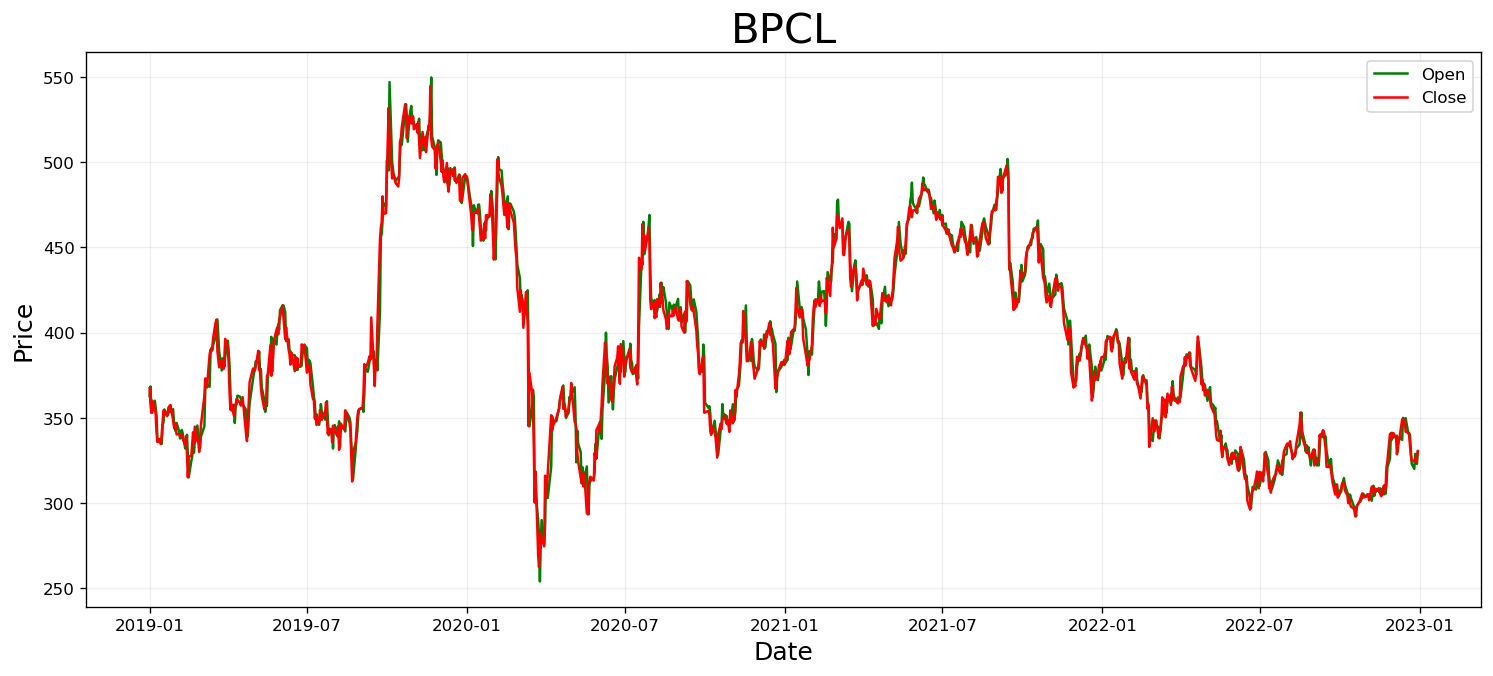

In [42]:
plt.figure(figsize = (15,6), dpi = 120)
sns.lineplot(bpcl.Open, color = 'green', label = 'Open')
sns.lineplot(bpcl.Close, color = 'red', label = 'Close')
plt.grid(alpha = 0.2)
plt.legend(loc='best')
plt.title('BPCL', fontsize = 25)
plt.ylabel('Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

## Decomposition od deterministic components

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose as sdc

<Figure size 1800x1800 with 0 Axes>

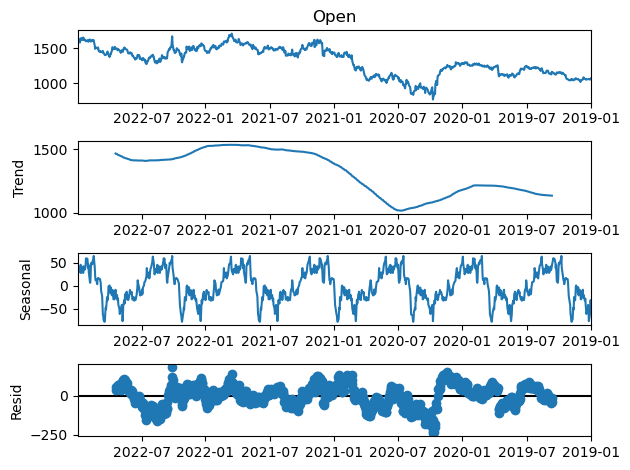

<Figure size 1800x1800 with 0 Axes>

In [64]:
res = sdc(hdfc.Open, model = 'additive', period = 150)
res.plot()
plt.figure(figsize = (15,15), dpi = 120)
